In [1]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

# sklearn
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# others
# import multiprocessing as mp
from xgboost import XGBRegressor
from tqdm import tqdm

# config
import sys
sys.path.append('/home/yusukemh/github/yusukemh/StatisticalDownscaling/writeup')
from config import C_COMMON, C_SINGLE, C_GRID, FILENAME
from util import load_data, XGB, NeuralNetwork, LinearRegression

# enable autoreload
%load_ext autoreload
%autoreload 2

2022-10-11 09:48:40.960589: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
columns = C_SINGLE
df_train, df_test = load_data(columns + C_COMMON, FILENAME)

# Model performance comparison

In [7]:
l_model = LinearRegression(columns=columns)
l_pred = l_model.evaluate(df_train, df_test)

,skn,rmse_lr,mae_lr
0,54.0,4.833861,3.558593
1,79.0,6.301111,4.208636
2,338.0,2.818706,2.123845
3,250.0,2.189325,1.443336
4,267.0,2.243758,1.505239
5,296.1,1.250883,0.888049
6,311.0,1.188327,0.864515
7,396.0,1.308114,0.960739
8,400.0,1.298378,0.976187
9,406.0,1.643493,1.254386


In [48]:
# XGBoost
x_model = XGB(
    params={
        'n_estimators': 120,
        'learning_rate': 0.070755,
        'max_depth': 2
    },
    columns=columns
)
x_pred = x_model.evaluate(df_train, df_test)
x_pred

,skn,rmse_xgb,mae_xgb
0,54.0,5.020365,3.724248
1,79.0,6.714039,4.751905
2,338.0,2.948576,2.119263
3,250.0,2.196315,1.437160
4,267.0,2.200451,1.434376
5,296.1,1.222167,0.723007
6,311.0,1.181025,0.671441
7,396.0,1.235662,0.781160
8,400.0,1.260604,0.864615
9,406.0,1.600808,1.175606


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2

def define_model(
    input_dim=20,
    n_units=512,
    activation='selu',#selu
    learning_rate=0.00001,
    loss='mse',
    batch_size=64
):
    inputs = Input(shape=(input_dim))
    x = Dense(units=n_units, activation=activation, kernel_regularizer=L2(l2=0.01))(inputs)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=n_units, activation=activation, kernel_regularizer=L2(l2=0.01))(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=n_units, activation=activation, kernel_regularizer=L2(l2=0.01))(x)
    x = Dropout(rate=0.5)(x)# serves as regularization
    outputs = Dense(units=1, activation='softplus')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
        loss=loss,
        metrics=[RootMeanSquaredError()]
    )
    return model, batch_size
n_model = NeuralNetwork(
    params={
        'n_units': 559,
        'learning_rate': 0.0004886843292039,
        'input_dim': 16,
        'batch_size': 256,
        'loss': 'mse'
    },
    columns=columns,
    model_func=define_model
)

In [4]:
n_pred = n_model.evaluate(df_train, df_test)

  0%|          | 0/24 [00:00<?, ?it/s]2022-08-09 01:29:15.338935: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-09 01:29:15.340828: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-09 01:29:15.410430: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: NVIDIA GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-08-09 01:29:15.410487: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-09 01:29:15.413362: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-09 01:29:15.413456: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully op

In [8]:
n_pred.merge(l_pred, left_on='skn', right_on='skn')

,skn,rmse_nn,mae_nn,rmse_lr,mae_lr
0,54.0,4.706835,3.156515,4.833861,3.558593
1,79.0,6.241887,3.912455,6.301111,4.208636
2,338.0,2.697565,1.827145,2.818706,2.123845
3,250.0,2.322117,1.331094,2.189325,1.443336
4,267.0,2.350901,1.443302,2.243758,1.505239
5,296.1,1.120728,0.629470,1.250883,0.888049
6,311.0,1.184260,0.581202,1.188327,0.864515
7,396.0,1.267793,0.740079,1.308114,0.960739
8,400.0,1.367699,0.880745,1.298378,0.976187
9,406.0,1.648682,1.175153,1.643493,1.254386


In [10]:
n_pred['rmse_nn'].mean(), l_pred['rmse_lr'].mean()

(2.7220337888275448, 2.811234342108683)

# site specific hyperparameter for NN

In [2]:
from hyperparameters import NN_PARAMS

In [23]:
ret_vals = []
for item in tqdm(NN_PARAMS):
    station_model = NeuralNetwork(
        columns=columns,
        params=item['params'],
        model_func=define_model
    )
    r = station_model.evaluate_by_station(df_train, df_test, skn=item['skn'])
    ret_vals.append(r)

100%|██████████| 24/24 [11:09<00:00, 27.88s/it]


In [25]:
temp = pd.DataFrame(ret_vals).merge(l_pred, left_on='skn', right_on='skn')
temp['rmse_nn'].mean(), temp['rmse_lr'].mean()

(2.7416193234218524, 2.8112343421086834)

# try data generator

In [3]:
skn = 54
df_train_station = df_train[skn == 54]
df_test_station = 

,skn,year,month,data_in,lat,lon,air2m,air1000_500,hgt500,hgt1000,...,shum700,shum925,skt,slp,elevation,season_wet,fold,len,cumsum,inner_fold
0,54.0,1948,1,5.370000,19.429741,-155.257146,295.39603,31.299995,5799.5483,121.483870,...,2.945999,9.869999,23.385218,1014.08490,3970.00,1,0,21,21,0
1,79.0,1948,1,6.170000,19.548635,-155.300557,295.39603,31.299995,5799.5483,121.483870,...,2.945999,9.869999,23.385218,1014.08490,5170.00,1,0,21,21,0
2,338.0,1948,1,30.890000,20.758467,-156.245523,295.39603,31.299995,5799.5483,121.483870,...,2.945999,9.869999,23.385218,1014.08490,7030.00,1,0,21,21,0
3,250.0,1948,1,5.270000,20.648174,-156.398497,295.30087,31.379990,5799.2256,121.258064,...,2.826000,9.923000,23.754120,1013.94574,1900.00,1,0,21,21,0
4,267.0,1948,1,7.800000,20.700140,-156.355519,295.30087,31.379990,5799.2256,121.258064,...,2.826000,9.923000,23.754120,1013.94574,3005.00,1,0,21,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14757,1020.1,1999,11,2.350000,21.981570,-159.342206,297.49582,30.769989,5860.4670,155.966660,...,2.562000,11.216000,25.869417,1018.15094,103.00,1,3,24,14762,4
14758,1075.0,1999,11,1.860000,22.130187,-159.658870,297.49582,30.769989,5860.4670,155.966660,...,2.562000,11.216000,25.869417,1018.15094,3600.00,1,3,24,14762,4
14759,1117.0,1999,11,8.880000,22.213196,-159.472201,297.49582,30.769989,5860.4670,155.966660,...,2.562000,11.216000,25.869417,1018.15094,295.00,1,3,24,14762,4
14760,1134.0,1999,11,3.400000,22.211941,-159.407202,297.49582,30.769989,5860.4670,155.966660,...,2.562000,11.216000,25.869417,1018.15094,315.00,1,3,24,14762,4


# does the number of samples affect the performance?

In [102]:
df_train[df_train['skn'] == 54].shape[0] * 0.05

31.1

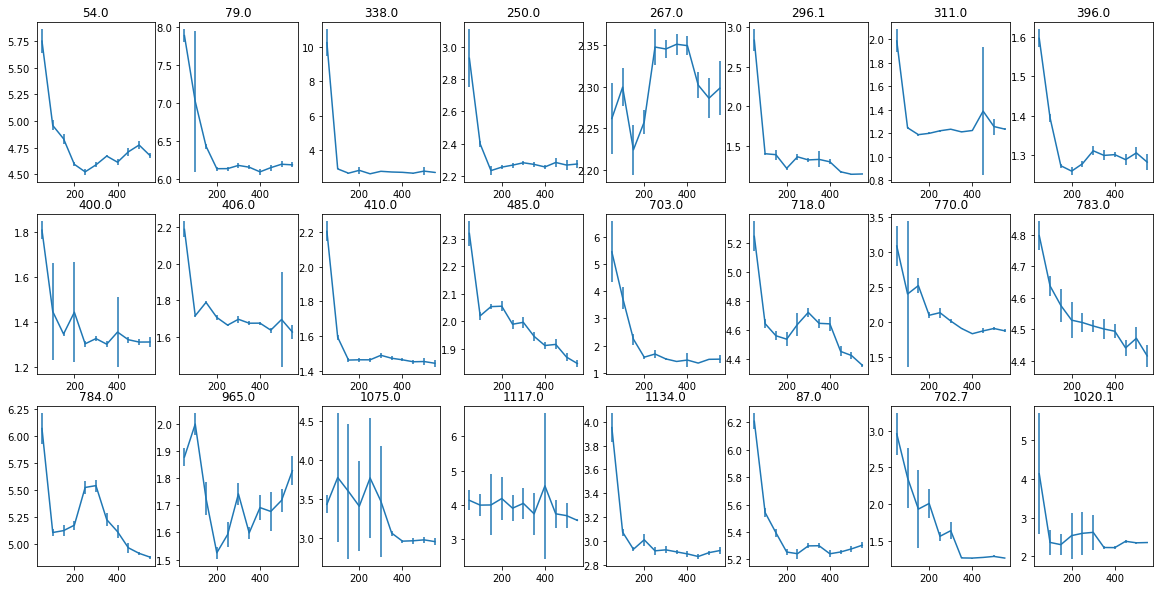

In [27]:
fig, axs = plt.subplots(3, 8, figsize=(20,10))
for ax, skn in zip(axs.flatten(), df_train['skn'].unique()):
    x, y, yerr = [], [], []
    # for p in range(5, 105, 5):
    for p in range(50, 600, 50):
        df = pd.read_csv(f'nn_hyperparameter_tuning/obtain_result/n_{p}_no_retrain.csv')
        df = df[df['skn'] == skn]
        x.append(p)
        y.append(df['rmse_nn'].values)
        yerr.append(df['rmse_std_nn'].values)
    ax.set_title(skn)
    ax.errorbar(x=x, y=np.array(y).reshape(-1,), yerr=np.array(yerr).reshape(-1,))
    # ax.set_ylim((0,10))

In [4]:
from sklearn.linear_model import LinearRegression
# very_n but with linear regression
columns = C_SINGLE
df_train, df_test = load_data(columns + C_COMMON, FILENAME)
y_lr = []
for p in [i for i in range(50, 600, 50)]:
    rmse_n = []
    for skn in df_train['skn'].unique():
        df_train_station = df_train[df_train['skn'] == skn].iloc[-p:]
        df_test_station = df_test[df_test['skn'] == skn]
        x_train, x_test = np.array(df_train_station[columns]), np.array(df_test_station[columns])
        y_train, y_test = np.array(df_train_station['data_in']), np.array(df_test_station['data_in'])
        
        linear_regression = LinearRegression()
        linear_regression.fit(x_train, y_train)
        y_pred = linear_regression.predict(x_test)
        
        rmse_n.append(mean_squared_error(y_test, y_pred, squared=False))
    y_lr.append(np.mean(rmse_n))
    

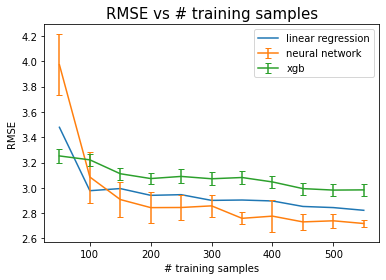

In [6]:
# station 784 is noisy
skns = df_train['skn'].unique()
# skns = skns[skns != 784]

x = range(50, 600, 50)
y_nn, yerr_nn = np.zeros((len(x), len(skns))), np.zeros((len(x), len(skns)))
y_xgb, yerr_xgb = np.zeros((len(x), len(skns))), np.zeros((len(x), len(skns)))
for i, p in enumerate(x):
    # nn
    df = pd.read_csv(f'nn_hyperparameter_tuning/obtain_result/n_{p}_no_retrain.csv')
    for j, skn in enumerate(skns):
        y_nn[i,j] = df[df['skn'] == skn]['rmse_nn']
        yerr_nn[i,j] = df[df['skn'] == skn]['rmse_std_nn']
        
    # xgb
    df = pd.read_csv(f"xgb_hyperparameter_tuning/obtain_result/n_{p}_.csv")
    for j, skn in enumerate(skns):
        y_xgb[i, j] = df[df['skn'] == skn]['rmse_xgb']
        yerr_xgb[i,j] = df[df['skn'] == skn]['rmse_std_xgb']
y_nn = y_nn.mean(axis=1)
yerr_nn = yerr_nn.mean(axis=1)
y_xgb = y_xgb.mean(axis=1)
yerr_xgb = yerr_xgb.mean(axis=1)

fig, ax = plt.subplots(1)
# simple plot for linear regression
ax.plot(x, y_lr, label='linear regression')
# error bar for NN
ax.errorbar(x=x[:], y=y_nn[:], yerr=yerr_nn[:], capsize=3, label='neural network')
# error bar for XGB
ax.errorbar(x=x[:], y=y_xgb[:], yerr=yerr_xgb[:], capsize=3, label='xgb')
ax.set_title('RMSE vs # training samples', fontsize=15)
ax.set_xlabel('# training samples')
ax.set_ylabel('RMSE')
ax.legend()
fig.savefig('error_plot')
print()

In [58]:
skns = df_train['skn'].unique()
skns = skns[skns != 784]

x = range(50, 600, 50)
y, yerr = np.zeros((len(x), len(skns))), np.zeros((len(x), len(skns)))
for i, p in enumerate(x):
    df = pd.read_csv(f'nn_hyperparameters/obtain_result/n_{p}_no_retrain.csv')
    for j, skn in enumerate(skns):
        y[i,j] = df[df['skn'] == skn]['rmse_nn']
        yerr[i,j] = df[df['skn'] == skn]['rmse_std_nn']

In [16]:
for iter in [10]:
    print(10)

10
